In [8]:
import numpy as np
import matplotlib.pyplot as plt
import nbsetup

In [10]:
from flux.dict import Dict
from flux.flux import Exam

exam = Exam('I')

F = Dict({
    'art' : exam.get('cid_cervi'),
    'ven' : exam.get('jugul-d'),
    'csf' : exam.get('c2_c3')
})

ModuleNotFoundError: No module named 'read'

Cardiac Cycle Duration: 0.795 s (75 bpm)


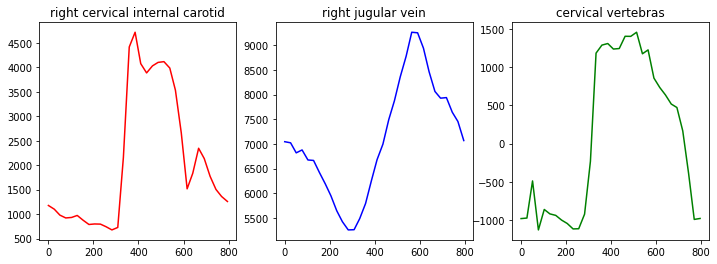

In [8]:
colors = {'art': 'red', 'ven': 'blue', 'csf': 'green'}

def plot_flux(t, F): 
    i=0
    plt.figure(figsize=(12, 4))
    for f, k in F: 
        y = np.array(f.debit)
        sgn = -1 if k in ['ven', 'csf'] else 1
        plt.subplot(1, 3, i+1)
        plt.plot(t, sgn * y, color=colors[k]) 
        plt.title(f.name)
        i+=1

t=F.art.time
T=t[-1] * 1e-3
print(f"Cardiac Cycle Duration: {T} s ({60/T:.0f} bpm)")
plot_flux(t, F)

In [9]:
T0 = np.array(F.art.debit).argmax()
print(T0)

def shift(v, t=T0): 
    return np.roll(v, -t + 1)

15


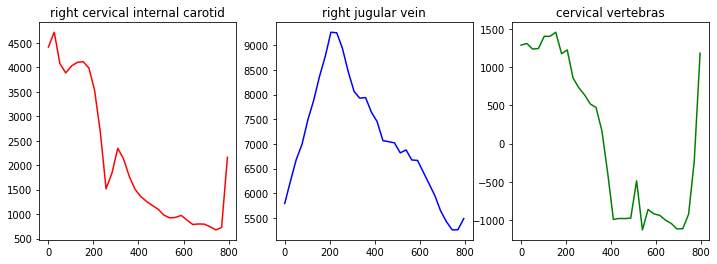

In [10]:
F0 = Dict(F.copy())
for f, k in F:
    F0[k].debit = shift(f.debit)
    
plot_flux(t, F0)

In [11]:
dt = T / len(t)

def volumes(fluxes, dt=dt):
    debits = Dict({k: shift(np.array(fk.debit)) for fk, k in fluxes})
    vols = Dict({k: dt * dk.cumsum() for dk, k in debits})
    return vols

def fluxes(fs):
    J = Dict({k: shift(np.array(fk.debit)) for fk, k in fs})
    return total(J)

def total (vs):
    return vs.reduce(lambda a, b, k: a + b)
    
def volume(fluxes):
    return total(volumes(fluxes))

In [12]:
Fluxes = Dict({
    'art' : exam.getAll('ci*', 'verteb'),
    'ven' : exam.getAll('jugul*'),
    'csf' : exam.getAll('c2_c3')
})

Volumes = Fluxes.fmap(volume)

V = Volumes

alpha = V.art[-1] / V.ven[-1]

V.blood = V.art - alpha * V.ven
V.ic = V.blood + V.csf

In [13]:
def center(V): 
    return V.fmap(lambda v: v - np.mean(v))

def floor(V):
    return V.fmap(lambda v: v - np.min(v))

def repeat(V, N=3):
    return Dict({
        k: np.concatenate([v for n in range(N)]) \
        for v, k in V
    })

def repeat_t(t, N=3): 
    T = t[-1] + t[-1] / (len(t) - 1)
    return np.concatenate([t + n * T for n in range(N)])

IVC : 1017.151 mm3
BVC : 1269.136 mm3
gain: 0.801 (-20%)


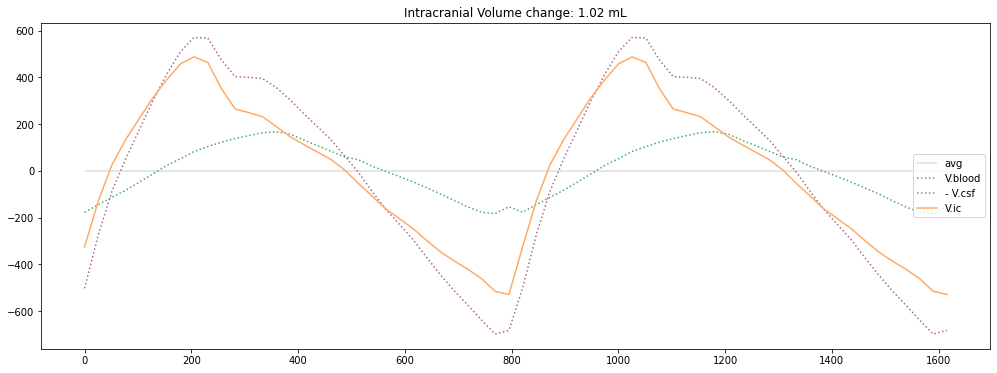

In [14]:
def plot_volumes(t, V, N=3):
    if N > 0:
        tN = repeat_t(np.array(t), N)
        VN = repeat(V, N)
        return plot_volumes(tN, VN, 0)
    plt.figure(figsize=(17, 6))
    plt.plot((0, np.max(t)), (0, 0), color="black", linewidth="0.2", label="avg")
    plt.plot(t, V.blood, color="#a68", linestyle="dotted", label="V.blood")
    plt.plot(t, -V.csf, color="#4a6", linestyle="dotted", label="- V.csf" )
    plt.plot(t, V.ic, color="#fa6", label="V.ic")
    plt.legend(loc='right')
    # IVC
    IVC = np.max(V.ic) - np.min(V.ic)
    plt.title(f'Intracranial Volume change: {IVC/1e3:.2f} mL')

V = center(V)
IVC = np.max(V.ic) - np.min(V.ic)
BVC = np.max(V.blood) - np.min(V.blood)
gain = IVC/BVC

print(f"IVC : {IVC:.3f} mm3")
print(f"BVC : {BVC:.3f} mm3")
print(f"gain: {gain:.3f} ({(gain-1) * 100:.0f}%)")
plot_volumes(t, center(V), 2)

In [15]:
def plot_fluxes(t, J, N=2):
    if N > 0:
        tN = repeat_t(np.array(t), N)
        JN = repeat(J, N)
        return plot_fluxes(tN, JN, 0)
    plt.figure(figsize=(17, 6))
    plt.plot((0, np.max(t)), (0, 0), color="black", linewidth="0.2", label="avg")
    plt.plot(t, J.art, color="red", label="J.art")
    plt.plot(t, J.csf, color="green", linestyle="dotted", label="J.csf" )
    plt.plot(t, J.ven, color="blue", label="J.ven")
    plt.legend(loc='right')
    plt.title(f'Blood and CSF fluxes')

In [16]:
J = Fluxes.fmap(fluxes)
J.ven = alpha * J.ven
J.csf = - J.csf

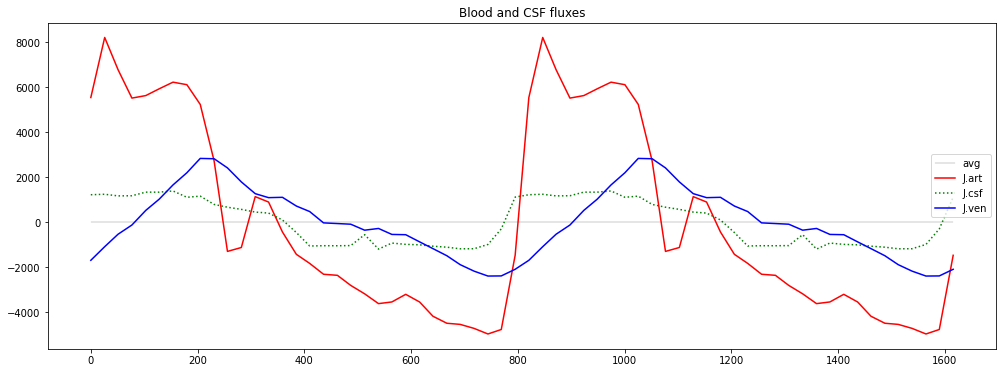

In [17]:
plot_fluxes(t, center(J), 2)

In [160]:
K = J.fmap(np.fft.fft)
Z = K.ven / K.art

Nspec = 3
spec = np.arange(0, Nspec)
Gain = np.abs(Z[:Nspec])
Phase = (-180/np.pi) * np.angle(Z[:Nspec])



In [161]:
#--- Theoretical Transfer Function ---

th = Dict()

# On R, C circuit:
th.gain = lambda w0: lambda w: np.sqrt(1 / (1 + (w/w0)**2))
th.phase = lambda w0: lambda w: (180/np.pi) * np.arctan(w/w0) 

# On R, r, C circuit
th.gain2 = lambda w0, a: lambda w:\
    np.sqrt((1 + (a * w / w0)**2) / (1 + (w / w0)**2))

th.phase2 = lambda w0, a: lambda w:\
    (180/np.pi) * np.arctan(w * (1 - a) / (1 + a**2 * w**2))

th.gain(1)(1)

0.7071067811865476

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


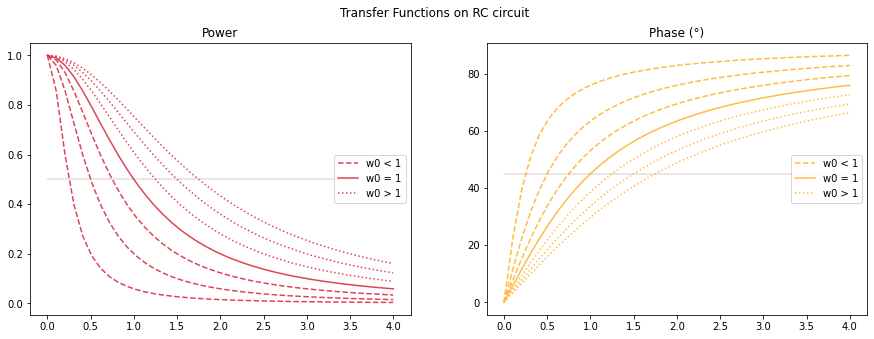

In [162]:
#--- Plot Transfer Diagrams ---

modes = [.25, .5, .75, 1, 1.25, 1.5, 1.75]
ws = np.linspace(0, 4, 40)

plt.figure(figsize=(15, 5))
plt.suptitle("Transfer Functions on RC circuit")

# Gain
plt.subplot(1, 2, 1)
for w0 in modes: 
    style = '-' if w0 == 1 else ('--' if w0 < 1 else ':')
    rel = '=' if w0 == 1 else ('<' if w0 < 1 else '>')
    if w0 in [.75, 1, 1.25]:
        plt.plot(ws, th.gain(w0)(ws) ** 2, color="#d45", linestyle=style, label=f'w0 {rel} 1')
    else: 
        plt.plot(ws, th.gain(w0)(ws) ** 2, color="#d45", linestyle=style)
    plt.plot((0, ws[-1]), (0.5, 0.5), linewidth=0.05)
    plt.title(f"Power")
    plt.legend(loc="right")
    
# Phase
plt.subplot(1, 2, 2)

for w0 in modes:
    style = '-' if w0 == 1 else ('--' if w0 < 1 else ':')
    rel = '=' if w0 == 1 else ('<' if w0 < 1 else '>')
    if w0 in [.75, 1, 1.25]:
        plt.plot(ws, th.phase(w0)(ws), color="#fb4", linestyle=style, label=f'w0 {rel} 1')
    else: 
        plt.plot(ws, th.phase(w0)(ws), color="#fb4", linestyle=style)   
    plt.plot((0, ws[-1]), (45, 45), linewidth=0.05)
    plt.title("Phase (°)")
    plt.legend(loc='right')

In [163]:
#--- Cut Pulsation ---
w0 = (.5 - 1) / (Gain[1] ** 2 - 1)

#--- Spectral Domain --- 
ws = np.linspace(0, Nspec - 1, 20)

#--- Cardiac Cycle --- 
CC = t[-1] / 1000 
f_cc = 1 / CC
f0 = w0 * f_cc

Transfer Function to 2nd Harmonic:
---------------------------------
fcc: 75.47 bpm
f0:  44.59 bpm	 (0.59 * fcc)


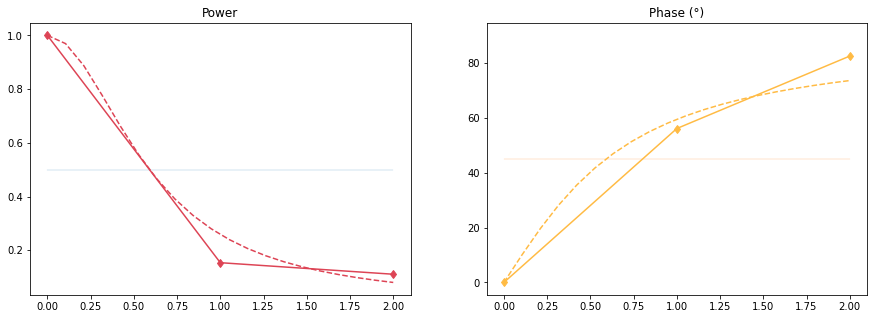

In [164]:
plt.figure(figsize=(15, 5))

# Gain
plt.subplot(1, 2, 1)
plt.plot((0, Nspec - 1), (0.5, 0.5), linewidth=0.2)
plt.plot(spec, Gain ** 2, marker="d", color="#d45")
plt.plot(ws, th.gain(w0)(ws) ** 2, color="#d45", linestyle="dashed")
plt.title(f"Power")

# Phase
plt.subplot(1, 2, 2)
plt.plot((0, 0), (90, 90))
plt.plot((0, Nspec - 1), (45, 45), linewidth=0.2)
plt.plot(spec, Phase, marker="d", color="#fb4", label="phase")
plt.plot(ws, th.phase(w0)(ws), color="#fb4", linestyle="dashed")
plt.title(f"Phase (°)")

#plt.suptitle("Transfer Function to 2nd Harmonic")

print("Transfer Function to 2nd Harmonic:")
print("---------------------------------")
print(f'fcc: {f_cc * 60:.2f} bpm')
print(f'f0:  {f0 * 60:.2f} bpm\t ({w0:.2f} * fcc)')

In [166]:
G_high = np.abs(Z[3])
G_high

0.028711032385221207